In [84]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder

data = pd.read_csv('../data/datathon_data.csv')

data = data.drop(['BELNR', 'BUKRS'], axis=1)

categorical_features = ['WAERS', 'KTOSL', 'PRCTR', 'BSCHL', 'HKONT']

# Add new columns to indicate if each categorical feature value is distinct (unique) or not
for feature in categorical_features:
    # For each feature, create a column indicating if the# value is unique (1) or not (0)
    data[f'{feature}_distinct'] = (~data[feature].duplicated(keep=False)).astype(int)

#OneHotEncode categorical features
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_features = encoder.fit_transform(data[categorical_features])

#Create a DataFrame with the encoded features
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_features))

#Drop the original categorical columns and concatenate the encoded columns
data = data.drop(categorical_features, axis=1)
data = pd.concat([data, encoded_df], axis=1)

X = data.drop('label', axis=1)
y = data['label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the decision tree classifier
clf = DecisionTreeClassifier() 
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 1.0


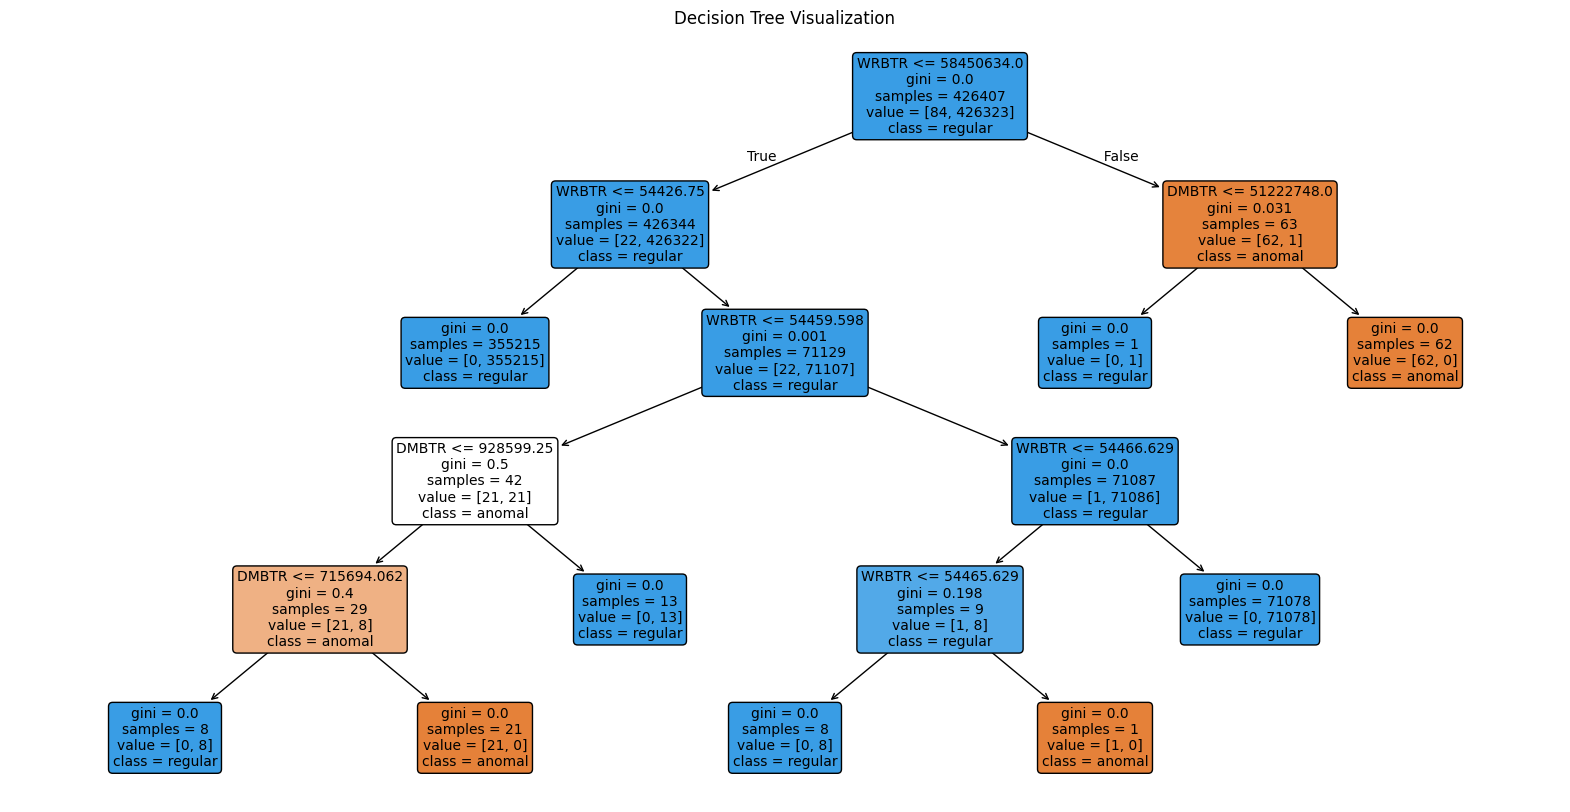

In [85]:
# Add these imports at the top of your notebook
import matplotlib.pyplot as plt
from sklearn import tree
import matplotlib.pyplot as plt

# After training the model and calculating accuracy, add this code:

# Visualize the decision tree
plt.figure(figsize=(20,10))  # Set the figure size (adjust as needed)

# Plot the tree
tree.plot_tree(clf, 
               feature_names=X.columns,  
               class_names=[str(c) for c in clf.classes_],
               filled=True,
               rounded=True,
               fontsize=10)

plt.title("Decision Tree Visualization")
#plt.savefig('decision_tree.png', dpi=300, bbox_inches='tight')  # Optional: save as image file
plt.show()

In [86]:
from sklearn.tree import _tree

def extract_anomaly_rules(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    anomaly_rules = []

    def recurse(node, depth, rule):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            # Left subtree
            recurse(tree_.children_left[node], depth + 1, 
                    rule + [f"({name} <= {threshold})"])
            # Right subtree
            recurse(tree_.children_right[node], depth + 1, 
                    rule + [f"({name} > {threshold})"])
        else:
            # Leaf node - check if it's an anomaly class
            if tree_.value[node][0][0] > 0:  # Assuming class 0 is "anomal"
                anomaly_rules.append((rule, tree_.value[node], tree_.n_node_samples[node]))

    recurse(0, 1, [])
    return anomaly_rules

def print_anomaly_rules(rules):
    for rule, value, samples in rules:
        class_label = 'anomal'
        print(" AND ".join(rule))

# Extract and print only anomaly rules
anomaly_rules = extract_anomaly_rules(clf, X.columns)
print_anomaly_rules(anomaly_rules)



(WRBTR <= 58450634.0) AND (WRBTR > 54426.75) AND (WRBTR <= 54459.59765625) AND (DMBTR <= 928599.25) AND (DMBTR > 715694.0625)
(WRBTR <= 58450634.0) AND (WRBTR > 54426.75) AND (WRBTR > 54459.59765625) AND (WRBTR <= 54466.62890625) AND (WRBTR > 54465.62890625)
(WRBTR > 58450634.0) AND (DMBTR > 51222748.0)
